********************

#### 탐색 결과를 소개하기 앞서 대회에서 제공하는 해당 데이터는 대회 진행을 목적으로 적합한 샘플링 작업을 거친 데이터라는 점을 알려드립니다.

#### 소개할 내용들이 <font color = "red">실제 멜론 유저의 소비 패턴과는 전혀 무관</font>하며, <font color = "red">멜론 DJ 플레이리스트 서비스를 일반화할 수 없음</font>을 참고하여 주시기 바랍니다.

********************

# KAKAO Arena 3rd Compitition : Melon Playlist Continuation

## 대회 데이터 간단하게 EDA

<br><br><br><br><br>

In [31]:
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from konlpy.tag import Twitter
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='malgun')
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family = font_name)

In [2]:
pd.options.mode.chained_assignment = None

<br><br><br><br><br><br><br><br><br><br>

## 1. 곡 장르 코드 데이터 : `genre_gn_all.json`

### 데이터 불러오기 

In [3]:
genre_gn_all = pd.read_json('../data/genre_gn_all.json', typ = 'series')

In [4]:
# 장르코드 : gnr_code, 장르명 : gnr_name
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'})

In [5]:
genre_gn_all

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
...,...,...
249,GN2900,뮤지컬
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬
252,GN2903,국외뮤지컬


- 장르 코드는 **총 254개의 장르코드가 존재**하며 **30개의 대분류 장르코드**와 **224개의 상세 장르코드**로 분류할 수 있습니다.

<br>

### 대분류 장르코드 

- 대분류 장르코드는 장르코드(`gnr_code`)에서 **숫자 네 자리 중 뒷자리 두 자리가 `00`인 코드로 분류**할 수 있습니다.
- 대분류 장르는 총 30개가 있습니다.

In [6]:
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']

In [7]:
gnr_code

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


In [7]:
gnr_code.shape

(30, 2)

<br>

### 상세 장르코드

- 상세 장르코드는 장르코드(`gnr_code`)에서 **숫자 네 자리 중 뒷자리 두 자리가 `00`이 아닌 나머지 코드로 분류**할 수 있습니다.
- 상세 장르는 총 224개가 있습니다.

In [8]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

In [9]:
dtl_gnr_code

,dtl_gnr_code,dtl_gnr_name
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00
5,GN0105,'10-
...,...,...
247,GN2805,숙면유도
248,GN2806,반려동물
250,GN2901,세부장르전체
251,GN2902,국내뮤지컬


<br>

### 장르 코드 트리(Tree)

- 위에서 구분한 **대분류 장르코드와 상세 장르코드 앞자리 네 자리를 활용**하여 장르 코드 트리도 구성해볼 수 있습니다.

In [10]:
# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


In [11]:
# POP 장르(GN0900)의 상세 장르 살펴보기
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN0900']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
48,GN0900,POP,GN09,GN0901,세부장르전체
49,GN0900,POP,GN09,GN0902,얼터너티브팝
50,GN0900,POP,GN09,GN0903,올디스
51,GN0900,POP,GN09,GN0904,월드팝
52,GN0900,POP,GN09,GN0905,'60-'70
53,GN0900,POP,GN09,GN0906,'80-'90
54,GN0900,POP,GN09,GN0907,'00
55,GN0900,POP,GN09,GN0908,'10-


In [12]:
# 어린이/테교 장르(GN2200)의 상세 장르 살펴보기
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN2200']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
177,GN2200,어린이/태교,GN22,GN2201,유아동요
178,GN2200,어린이/태교,GN22,GN2202,창작동요
179,GN2200,어린이/태교,GN22,GN2203,영어동요
180,GN2200,어린이/태교,GN22,GN2204,영어동요
181,GN2200,어린이/태교,GN22,GN2205,영어동요
182,GN2200,어린이/태교,GN22,GN2206,영어동화
183,GN2200,어린이/태교,GN22,GN2207,만화
184,GN2200,어린이/태교,GN22,GN2208,자장가
185,GN2200,어린이/태교,GN22,GN2209,태교동화
186,GN2200,어린이/태교,GN22,GN2210,태교


<br><br><br>

## 2. 곡 별 메타 데이터 : `song_meta.json`

### 데이터 불러오기

In [13]:
song_meta = pd.read_json('../data/song_meta.json', typ = 'frame')

In [14]:
song_meta

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4
...,...,...,...,...,...,...,...,...,...
707984,[GN2001],19991219,The Best Best Of The Black President,65254,[166499],Coffin For Head Of State,[GN2000],[Fela Kuti],707984
707985,[GN0901],19860000,True Colors,44141,[11837],Change Of Heart,[GN0900],[Cyndi Lauper],707985
707986,"[GN0105, GN0101]",20160120,행보 2015 윤종신 / 작사가 윤종신 Live Part.1,2662866,[437],스치듯 안녕,[GN0100],[윤종신],707986
707987,"[GN1807, GN1801]",20131217,명상의 시간을 위한 뉴에이지 음악,2221722,[729868],숲의 빛,[GN1800],[Nature Piano],707987


In [15]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


In [16]:
song_meta.isnull().any()

song_gn_dtl_gnr_basket    False
issue_date                False
album_name                 True
album_id                  False
artist_id_basket          False
song_name                 False
song_gn_gnr_basket        False
artist_name_basket        False
id                        False
dtype: bool

In [18]:
song_meta[song_meta["album_name"].isnull()]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
143209,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20150522,None,2318271,[726168],사랑바보,"[GN0500, GN0600]",[민은서밴드],143209
291631,"[GN0105, GN0101]",20101108,None,1065178,[28772],빗속에서,[GN0100],[존박],291631
431110,"[GN0509, GN0601, GN0503, GN0606, GN0501]",20200208,None,10385717,[2203064],화면,"[GN0500, GN0600]",[Oowl Hannal (우울 한날)],431110
552088,"[GN0105, GN0601]",20101108,None,1065178,[28263],본능적으로 (Feat. Swings),"[GN0600, GN0100]",[강승윤],552088


- **총 707,989곡의 메타 정보가 담겨 있으며** 포함하는 값은 아래와 같습니다.
  + `song_gn_dtl_gnr_basket` : 상세 장르 코드
  + `issue_date` : 곡 발매 일자 (yyyymmdd)
  + `album_name` : 앨범 명
  + `album_id` : 앨범 아이디
  + `artist_id_basket` : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
  + `song_name` : 곡 명
  + `song_gn_gnr_basket` : 대분류 장르코드
  + `artist_name_basket` : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
  + `id` : 곡 아이디

<br>

### 곡 별 매핑 되는 장르 수는?

In [19]:
# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

In [20]:
song_gnr_map

,song_id,gnr_code
0,0,GN0900
1,1,GN1600
2,2,GN0900
3,3,GN1100
4,4,GN1800
...,...,...
802854,707984,GN2000
802855,707985,GN0900
802856,707986,GN0100
802857,707987,GN1800


In [21]:
# 1. 곡 별 장르 개수 count 테이블 생성 : song_gnr_count
song_gnr_count = song_gnr_map.groupby('song_id').gnr_code.nunique().reset_index(name = 'mapping_gnr_cnt')

# 2. 1번에서 생성한 테이블을 가지고 매핑된 장르 개수 별 곡 수 count 테이블 생성 : gnr_song_count
gnr_song_count = song_gnr_count.groupby('mapping_gnr_cnt').song_id.nunique().reset_index(name = '매핑된 곡 수')

# 3. 2번 테이블에 비율 값 추가
gnr_song_count.loc[:, '비율(%)'] = round(gnr_song_count['매핑된 곡 수']/sum(gnr_song_count['매핑된 곡 수'])*100, 2)
gnr_song_count = gnr_song_count.reset_index().rename(columns = {'mapping_gnr_cnt' : '장르 수'})
gnr_song_count[['장르 수', '매핑된 곡 수', '비율(%)']]

,장르 수,매핑된 곡 수,비율(%)
0,1,612806,86.69
1,2,92378,13.07
2,3,1694,0.24
3,4,48,0.01
4,5,1,0.00
5,6,3,0.00


- **대부분의 곡들은 한 개의 대분류 장르와 매핑**되어 있습니다.
- 전체 곡의 약 13%는 2개 이상의 대분류 장르를 가지며 아래 임의 예시입니다.

In [22]:
#song_gnr_count[song_gnr_count['mapping_gnr_cnt'] >= 2]
song_meta[song_meta['id'] == 456506] 

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
456506,"[GN0403, GN0101, GN1501, GN1504]",20060731,오버 더 레인보우 OST,321962,[1928],그리운 건 어쩔 수 없어,"[GN0400, GN1500, GN0100]",[환희],456506


<br>

### 가장 많이 매핑 되는 장르는?

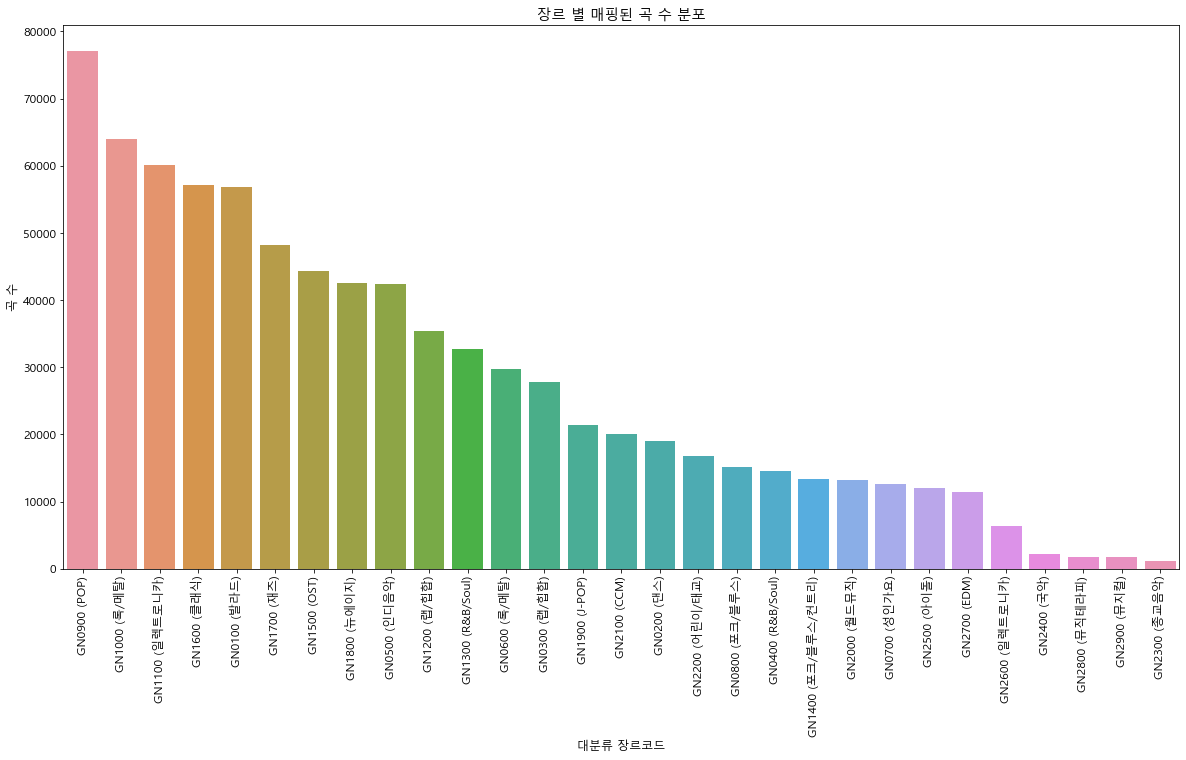

In [32]:
# 1. 장르 별 곡 수 count 테이블 생성 : gnr_count
gnr_count = song_gnr_map.groupby('gnr_code').song_id.nunique().reset_index(name = 'song_cnt')

# 2. 1번 테이블과 장르 meta와 join
gnr_count = pd.merge(gnr_count, gnr_code.loc[:, ['gnr_code', 'gnr_name']], how = 'left', on = 'gnr_code')
gnr_count['gnr_code_name'] = gnr_count['gnr_code'] + ' (' + gnr_count['gnr_name'] + ')'

# 3. 매핑이 되지 않은 일부 곡들은 제거
gnr_count = gnr_count[['gnr_code_name', 'song_cnt']].dropna()

# 4. 많은 곡이 매핑된 순 기준으로 내림차순 리스트 생성
gnr_list_desc = gnr_count.sort_values('song_cnt', ascending = False).gnr_code_name

# 5. plotting
gnr_code_name_plot = sns.barplot(x = 'gnr_code_name', y = 'song_cnt', data = gnr_count, order = gnr_list_desc)
gnr_code_name_plot.set_title('장르 별 매핑된 곡 수 분포')
gnr_code_name_plot.set_xlabel('대분류 장르코드')
gnr_code_name_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

- **POP 장르(`GN0900`)의 곡 비중이 가장 높았고**, 국악, 뮤지컬, 뮤직테라피, 종교음악 등의 장르 비중은 1% 미만의 비중을 보입니다.
- 아이돌 아티스트 관련 장르인 아이돌 장르(`GN2500`)와 댄스 장르(`GN0200`) 비중도 비교적 낮게 나타나는 점이 보입니다.

<br>

### 발매 년도 별 곡 비중은?

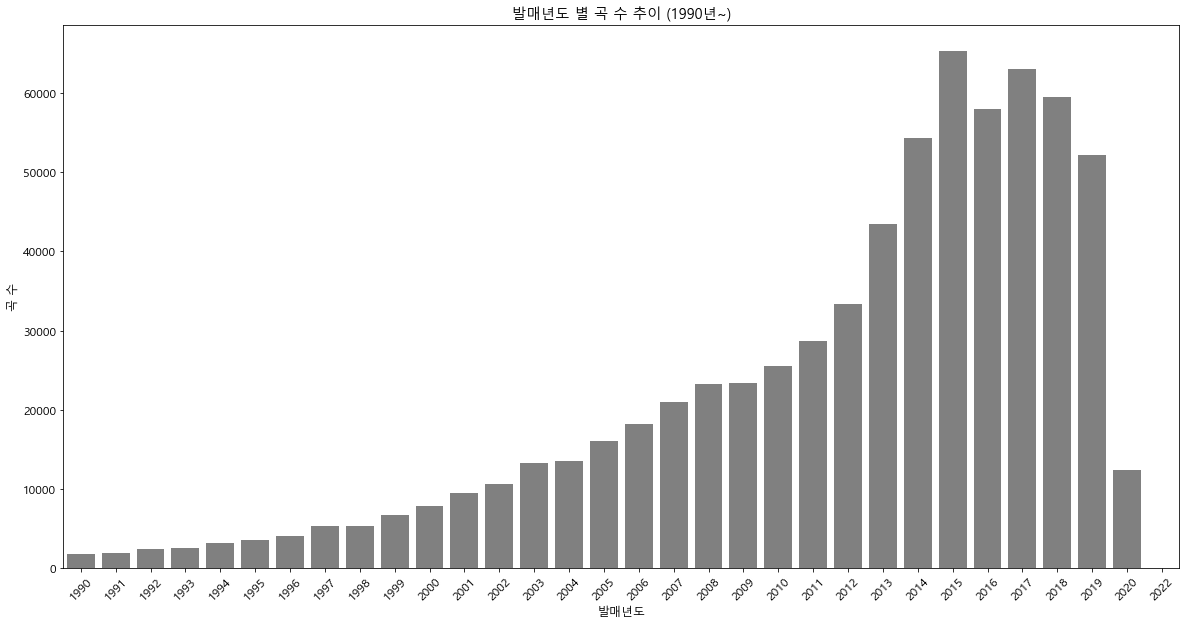

In [33]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 45)
plt.show()

- 1990년 이후로 각 곡들의 발매년도 별 곡의 비중을 확인해본 결과 **2014~2019년도에 발매된 곡의 비중**이 높았습니다.  
  (실제 전체 메타 풀에서 약 50% 정도의 비중을 보임)

<br><br><br>

## 3. 학습 데이터 : `train.json`

### 데이터 불러오기

In [34]:
train = pd.read_json('../data/train.json', typ = 'frame')

In [35]:
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


- 학습 데이터에는 **총 115,071개 플레이리스트 정보가 담겨져 있으며** 포함하는 값은 아래와 같습니다.
  + `tags` : 플레이리스트에 매핑된 태그
  + `id` : 플레이리스트 아이디
  + `plylst_title` : 플레이리스트 명
  + `songs` : 플레이리스트 내 수록된 곡 아이디
  + `like_cnt` : 플레이리스트 좋아요 횟수
  + `updt_date` : 플레이리스트 업데이트 일시

In [37]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = train[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

In [39]:
plylst_song_map

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285866,100389,111365
5285867,100389,51373
5285868,100389,640239
5285869,100389,13759


In [40]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

In [41]:
plylst_tag_map

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


In [42]:
train_uniq_song_cnt = plylst_song_map.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag_map.tags.nunique() # 유니크 태그 수

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

곡 수 : 615142
태그 수 : 29160


<br>

### 플레이리스트 별 곡/태그/장르 수 분포는?

#### 수록곡 

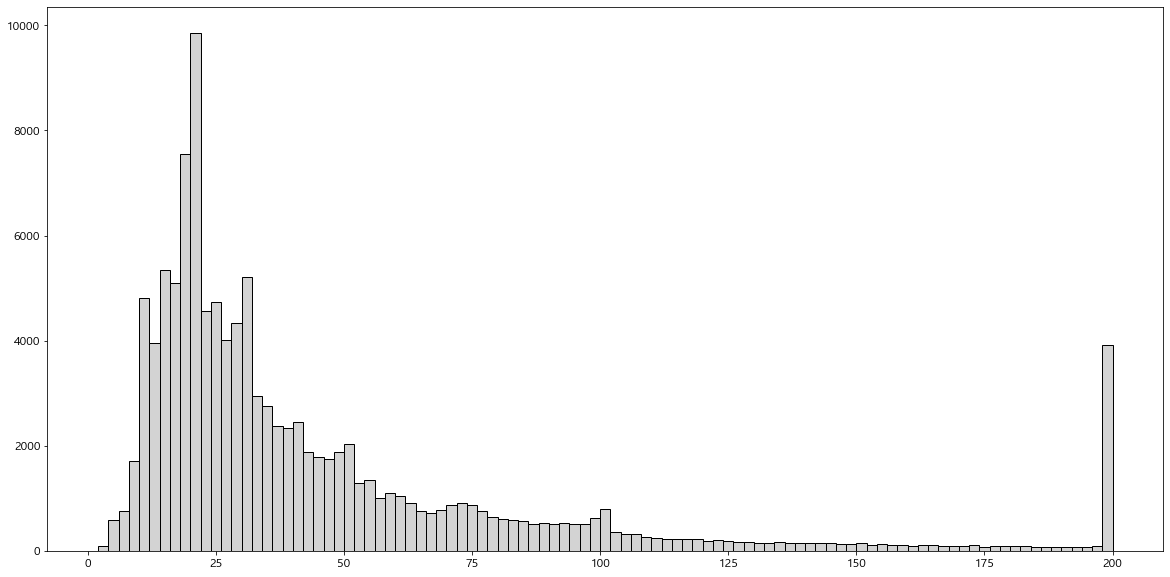

In [43]:
# 1. 플레이리스트 별 수록곡 수 count 테이블 생성 : plylst_song_cnt
plylst_song_cnt = pd.DataFrame(plylst_song_map.groupby('id').songs.nunique())

# 2-1. grid setting
grid_list = [i*2 for i in range(1, 101)]

# 2-2. plotting
plt.hist(plylst_song_cnt['songs'], grid_list, color = "lightgrey", edgecolor = "black")
plt.show()

In [44]:
round(plylst_song_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
songs,1.0,19.0,30.0,45.94,54.0,200.0,43.95


- 플레이리스트 별 수록된 곡 수의 분포를 확인해본 결과 **평균 약 46개**(중앙값 30개)**의 곡이 수록**되어 있으며 최대 200곡의 수록곡을 포함한 플레이리스트가 존재합니다.

#### 태그

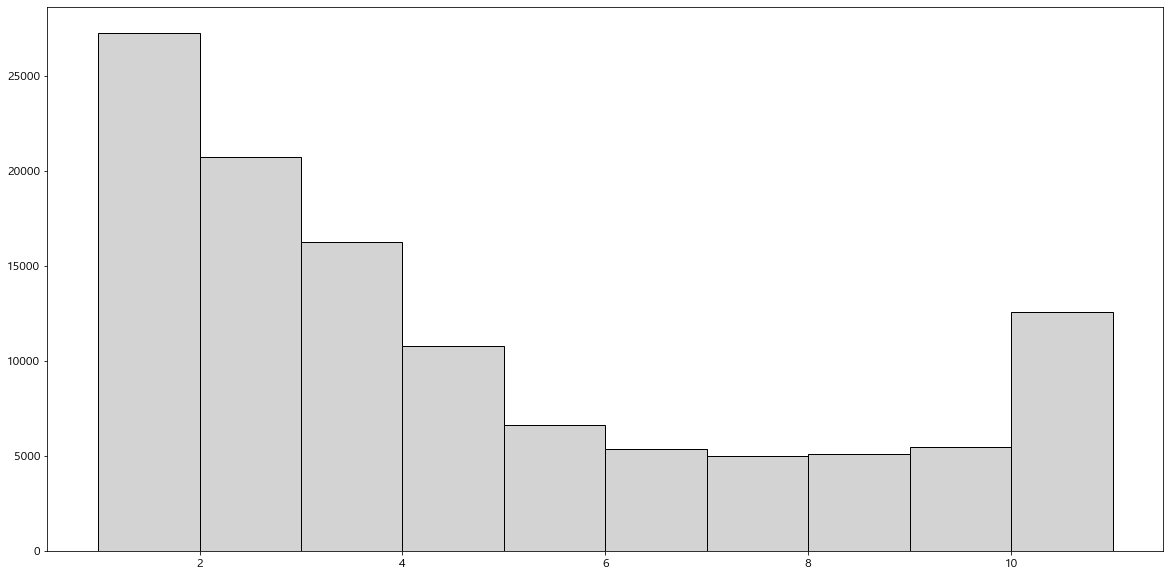

In [45]:
# 1. 플레이리스트 별 매핑 태그 수 count 테이블 생성 : plylst_tag_cnt
plylst_tag_cnt = pd.DataFrame(plylst_tag_map.groupby('id').tags.nunique())

# 2. plotting
plt.hist(plylst_tag_cnt['tags'], range(1, 12), color = "lightgrey", edgecolor = "black")
plt.show()

In [46]:
round(plylst_tag_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags,1.0,2.0,3.0,4.14,6.0,11.0,3.07


- 플레이리스트 당 **태그는 평균 약 4.1개**(중앙값 3개)**가 포함**되어 있으며 가장 많은 태그 수는 11개 입니다.

#### 장르

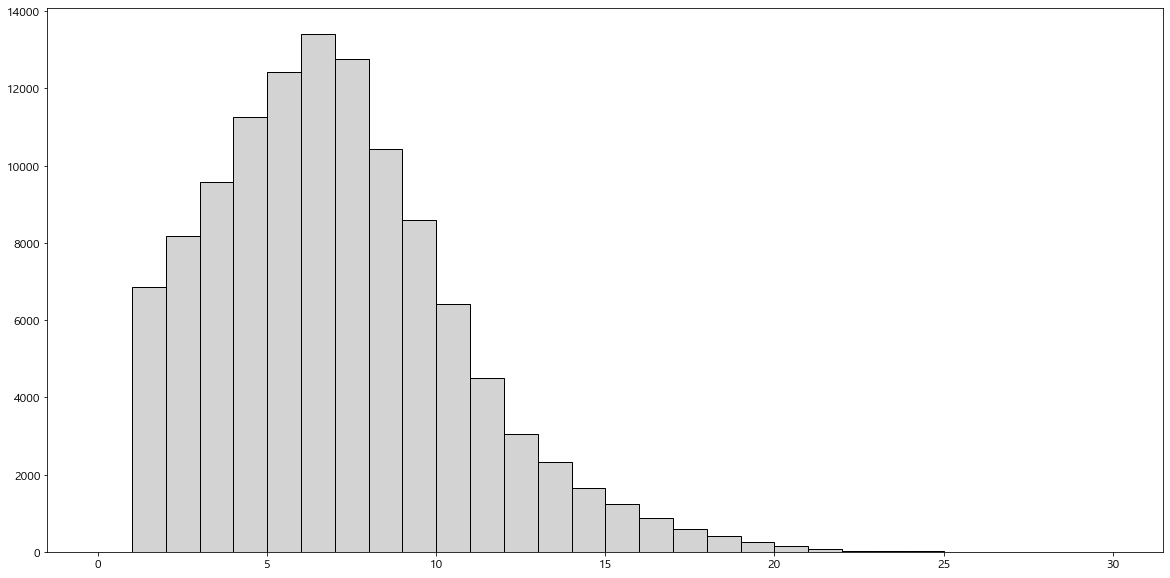

In [47]:
# 1-1. join 목적으로 곡 아이디 integer to string 변환
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# 1-2. 플레이리스트-곡 테이블 plylst_song_map + 곡-장르 테이블 song_gnr_map join
plylst_song_gnr_map = pd.merge(plylst_song_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 2. 플레이리스트 별 곡 장르 수 count 테이블 생성 : plylst_song_gnr_cnt
plylst_song_gnr_cnt = pd.DataFrame(plylst_song_gnr_map.groupby('id').gnr_code.nunique())

# 3. plotting
plt.hist(plylst_song_gnr_cnt['gnr_code'], range(0, 31), color = "lightgrey", edgecolor = "black")
plt.show()

In [41]:
round(plylst_song_gnr_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
gnr_code,0.0,4.0,6.0,6.55,9.0,26.0,3.62


- 플레이리스트에 수록된 곡에서 대분류 장르 수 분포를 확인해본 결과 플레이리스트 당 **평균 6.6개**(중앙값 6개)**의 장르를 포함**하고 있습니다. 

<br>

### 곡/태그/플레이리스트명 중복 비율은?

#### 중복 수록 곡 비중

In [48]:
# 1. 곡 별 수록된 플레이리스트 개수 count 테이블 생성 : song_plylst_cnt
song_plylst_cnt = plylst_song_map.groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 수록 구분 : 곡 별 수록된 플레이리스트가 한 개면 '단일 수록', 두 개 이상이면 '중복 수록'
song_plylst_cnt = song_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(song_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 수록', '중복 수록'])
)

# 3. 단일/중복 수록 구분 별 곡 수 count 테이블 생성 : song_plylst_mapping_division
song_plylst_mapping_division = pd.DataFrame(song_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
song_plylst_mapping_division.rename(columns = {'songs' : '곡 수'}, inplace = True)
song_plylst_mapping_division.loc[:, '비율(%)'] = round(song_plylst_mapping_division['곡 수']/sum(song_plylst_mapping_division['곡 수'])*100, 2)
song_plylst_mapping_division = song_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 수록 여부'})
song_plylst_mapping_division[['중복 수록 여부', '곡 수', '비율(%)']]

,중복 수록 여부,곡 수,비율(%)
0,단일 수록,299028,48.61
1,중복 수록,316114,51.39


- **수록 곡의 약 51%는 두 개 이상의 플레이리스트에 중복 수록**된 곡 입니다.

#### 아래는 중복 수록 곡 중 많이 수록된 횟수 기준 상위 30곡 입니다.

In [49]:
# 1. song_plylst_cnt 테이블에서 중복 수록 곡 중 수록 횟수 기준 상위 30곡 필터링 테이블 생성 : duplicate_song_top30
duplicate_song_top30 = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '중복 수록'].nlargest(30, 'mapping_plylst_cnt')

# 2-1. join 목적으로 곡 아이디 integer to string 변환
duplicate_song_top30['songs'] = duplicate_song_top30['songs'].astype(str)
song_meta['id'] = song_meta['id'].astype(str)

# 2-2 상위 30곡 테이블 duplicate_song_top30 + 곡 메타 song_meta join
(
    pd.merge(duplicate_song_top30, song_meta[['id', 'song_name', 'artist_name_basket']],
             how = 'left', left_on = 'songs', right_on = 'id')
    [['songs', 'song_name', 'artist_name_basket', 'mapping_plylst_cnt']]
    .rename(columns = {'songs' : '곡 아이디', 'song_name' : '곡 명', 'artist_name_basket' : '아티스트 명', 'mapping_plylst_cnt' : '수록 횟수'})
)

,곡 아이디,곡 명,아티스트 명,수록 횟수
0,144663,밤편지,[아이유],2175
1,116573,안아줘,[정준일],2121
2,357367,비,[폴킴],1981
3,366786,가끔 미치도록 네가 안고 싶어질 때가 있어,[가을방학],1919
4,654757,눈의 꽃,[박효신],1647
5,133143,"그대와 나, 설레임 (Feat. 소울맨)",[어쿠스틱 콜라보],1633
6,349492,어떤이별,[임승부],1599
7,675115,야생화,[박효신],1598
8,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)],1544
9,42155,벙어리,[홍아],1540


#### 아래는 단일 수록 곡 중 가장 많은 곡이 수록된 장르 상위 30개 입니다.

In [50]:
# 1. song_plylst_cnt 테이블에서 단일 수록 곡만 필터링 하여 테이블 생성 : single_song
single_song = song_plylst_cnt[song_plylst_cnt['mapping_plylst_cnt_category'] == '단일 수록']

# 2-1. join 목적으로 곡 아이디 integer to string 변환
single_song['songs'] = single_song['songs'].astype(str)

# 2-2. 단일 수록 곡 테이블 single_song + 곡 메타 song_meta join : 아티스트 기준 single_song_artist, 장르 기준 single_song_gnr
single_song_artist = pd.merge(single_song, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id')
single_song_gnr = pd.merge(single_song, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 수록 곡 개수 기준 상위 30개 장르 : single_song_gnr_cnt
single_song_gnr_cnt = single_song_gnr.groupby('gnr_code').songs.nunique().reset_index(name = 'song_cnt')
(
    pd.merge(single_song_gnr_cnt, genre_gn_all, how = 'left', on = 'gnr_code')[['gnr_code', 'gnr_name', 'song_cnt']]
    .rename(columns = {'gnr_code' : '대분류 장르코드', 'gnr_name' : '장르명', 'song_cnt' : '수록 곡 수'})
    .sort_values('수록 곡 수', ascending = False)
)

,대분류 장르코드,장르명,수록 곡 수
15,GN1600,클래식,32841
8,GN0900,POP,30987
9,GN1000,록/메탈,30028
10,GN1100,일렉트로니카,25725
16,GN1700,재즈,23158
17,GN1800,뉴에이지,19370
14,GN1500,OST,16855
11,GN1200,랩/힙합,15054
0,GN0100,발라드,14575
12,GN1300,R&B/Soul,13136


<br>

#### 중복 매핑 태그 비중

In [51]:
# 1. 태그 별 수록된 플레이리스트 개수 count 테이블 생성 : tag_plylst_cnt
tag_plylst_cnt = plylst_tag_map.groupby('tags').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 2. 단일/중복 매핑 구분 : 태그 별 매핑된 플레이리스트가 한 개면 '단일 매핑', 두 개 이상이면 '중복 매핑'
tag_plylst_cnt = tag_plylst_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(tag_plylst_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['단일 매핑', '중복 매핑'])
)

# 3. 단일/중복 매핑 구분 별 태그 수 count 테이블 생성 : tag_plylst_mapping_division
tag_plylst_mapping_division = pd.DataFrame(tag_plylst_cnt.groupby('mapping_plylst_cnt_category').count())

# 4. 3번 테이블에 비율 값 추가
tag_plylst_mapping_division.rename(columns = {'tags' : '태그 수'}, inplace = True)
tag_plylst_mapping_division.loc[:, '비율(%)'] = round(tag_plylst_mapping_division['태그 수']/sum(tag_plylst_mapping_division['태그 수'])*100, 2)
tag_plylst_mapping_division = tag_plylst_mapping_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 매핑 여부'})
tag_plylst_mapping_division[['중복 매핑 여부', '태그 수', '비율(%)']]

,중복 매핑 여부,태그 수,비율(%)
0,단일 매핑,17431,59.78
1,중복 매핑,11729,40.22


- 태그의 매핑 중복 비율을 확인해본 결과 **전체 대비 약 40.2%는 두 개 이상 플레이리스트에 매핑된 태그**이며  
  한 개 플레이리스트에만 매핑된 태그는 과반 이상의 비중을 차지합니다.

<br>

#### 플레이리스트명 중복 비중

In [52]:
# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title = train[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 : plylst_id_cnt
plylst_id_cnt = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 3. 플레이리스트 명 중복 구분 : 서로 다른 플레이리스트 아이디로 겹치는 플레이리스트 이름이 없으면 '중복 없음', 그 외 '중복 있음'
plylst_id_cnt = plylst_id_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_cnt_division
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category').count())

# 5. 4번 테이블에 비율 값 추가
plylst_id_cnt_division.rename(columns = {'mapping_plylst_cnt' : '플레이리스트 아이디 수'}, inplace = True)
plylst_id_cnt_division.loc[:, '비율(%)'] = round(plylst_id_cnt_division['플레이리스트 아이디 수']/sum(plylst_id_cnt_division['플레이리스트 아이디 수'])*100, 2)
plylst_id_cnt_division = plylst_id_cnt_division.reset_index().rename(columns = {'mapping_plylst_cnt_category' : '중복 이름 여부'})
plylst_id_cnt_division.loc[:, ['중복 이름 여부', '플레이리스트 아이디 수', '비율(%)']]

,중복 이름 여부,플레이리스트 아이디 수,비율(%)
0,중복 없음,108214,97.9
1,중복 있음,2317,2.1


- 또한 **플레이리스트 아이디는 다르지만 같은 이름을 갖는 플레이리스트도 전체 대비 약 2% 정도**로 소수 존재 합니다.
- 이러한 플레이리스트들은 대부분 곡 수와 태그 수도 비슷한 편이 많았습니다. 

<br>

### 많은 빈도를 보이는 태그는?

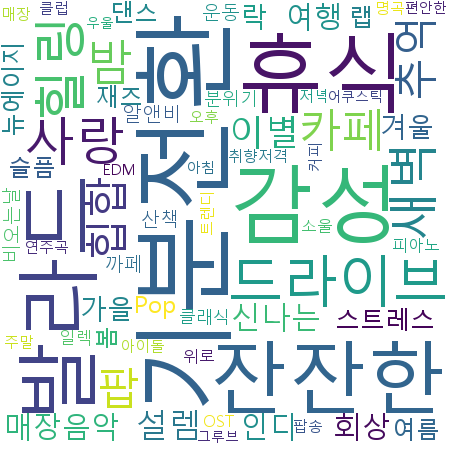

In [53]:
# 태그 별 매핑 빈도 수 저장 
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = font_path, background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

- 매핑 기준 상위 1,000번 이상 매핑된 태그를 살펴본 결과 **기분전환 태그명이 가장 높은 비중을 차지**하고 있으며  
  여름/가을/겨울 등 계절이나 드라이브, 카페, 매장음악 등 특정 상황과 어울리는 태그 등이 상위권에 분포되어 있습니다.
- 발라드, 힙합, 팝, 인디, 락, 댄스, 뉴에이지 등 **장르와 관련된 태그도 일부 상위권**에 속합니다.

<br>

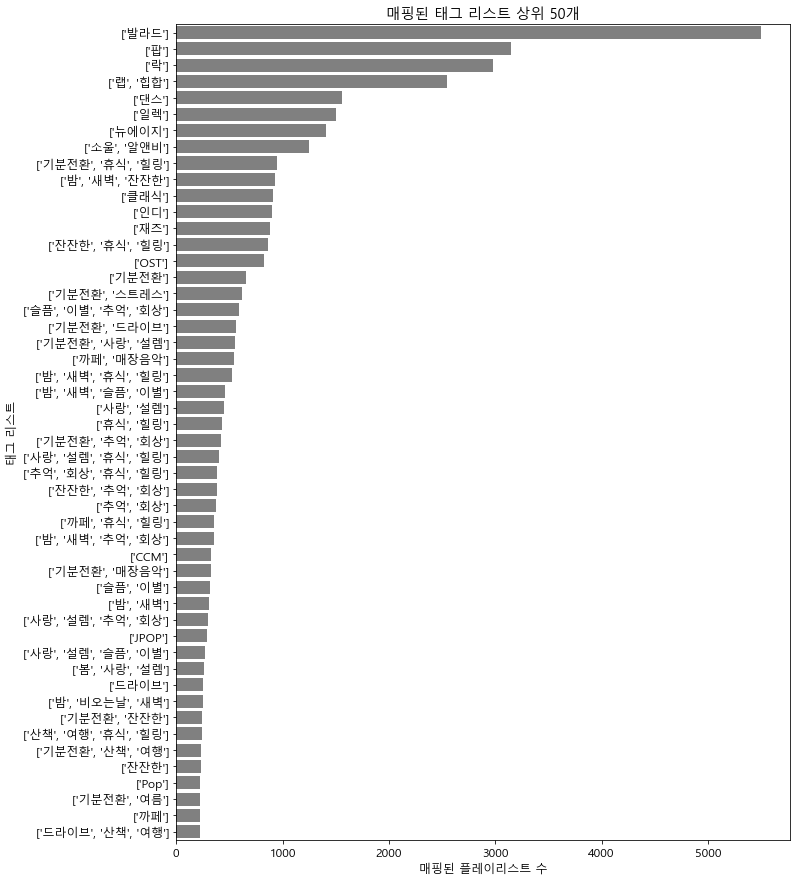

In [54]:
# 1. unnest 데이터프레임인 plylst_tag_map 테이블에서 태그 이름 정렬 후 list로 묶기
plylst_tag_list_sort = plylst_tag_map.sort_values(by = ['id', 'tags']).groupby('id').tags.apply(list).reset_index(name = 'tag_list')

# 2. 집계를 위해 1번 테이블에서 list 타입을 문자열 타입으로 변경
plylst_tag_list_sort['tag_list'] = plylst_tag_list_sort['tag_list'].astype(str)

# 3. 태그 리스트 별 매핑되는 플레이리스트 수 집계 테이블 생성 : tag_list_plylst_cnt
tag_list_plylst_cnt = plylst_tag_list_sort.groupby('tag_list').id.nunique().reset_index(name = 'plylst_cnt')

# 4. 매핑 수 기준 상위 50개 필터링
tag_list_plylst_cnt = tag_list_plylst_cnt.nlargest(50, 'plylst_cnt')

# 5. plotting
plt.figure(figsize = (11, 15))
tag_list_plylst_cnt_plot = sns.barplot(y = 'tag_list', x = 'plylst_cnt', data = tag_list_plylst_cnt, color = 'grey')
tag_list_plylst_cnt_plot.set_title('매핑된 태그 리스트 상위 50개')
tag_list_plylst_cnt_plot.set_xlabel('매핑된 플레이리스트 수')
tag_list_plylst_cnt_plot.set_ylabel('태그 리스트')
plt.show()

- 플레이리스트에 매핑된 태그 리스트를 기준으로 매핑 기준 상위 50개를 확인해본 결과  
  **다른 태그와 조합 없는 장르 관련 태그가 상위권을 차지**하고 있으며, 발라드 단일 태그가 가장 많았습니다.
- **이 밖에 가장 빈도가 높았던 기분전환 태그명은 휴식, 힐링 뿐만 아니라 스트레스, 드라이브, 사랑, 설렘 등 다양한 태그와 같이 조합을 이루는 케이스가 많았습니다.**

<br>

### 플레이리스트 태그 별 어떤 곡들이 수록되었을까?

In [55]:
# 1. 플레이리스트-곡 테이블 plylst_song_map + 플레이리스트-태그 테이블 plylst_tag_map join 테이블 생성 : plylst_song_tag_map
plylst_song_tag_map = pd.merge(plylst_song_map, plylst_tag_map, how = 'left', on = 'id')

# 2. 1번 테이블 plylst_song_tag_map + 곡 장르 테이블 song_gnr_map join
plylst_song_tag_map = pd.merge(plylst_song_tag_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 2번 테이블에서 장르 메타 join
gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'
gnr_code = gnr_code[['gnr_code', 'gnr_code_name']]
plylst_song_tag_map = pd.merge(plylst_song_tag_map, gnr_code, how = 'left', on = 'gnr_code')

# 4. 최종 테이블 필드 선택
plylst_song_tag_map = plylst_song_tag_map[['id', 'songs', 'tags', 'gnr_code_name']]

In [56]:
# 태그 = ['드라이브', '스트레스', '기분전환']
song_tag_map_sample_1 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그 = ['밤', '새벽', '잔잔한']
song_tag_map_sample_2 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그 = ['사랑', '설렘']
song_tag_map_sample_3 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['사랑', '설렘']), :]
# 태그 = ['추억', '회상']
song_tag_map_sample_4 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['추억', '회상']), :]
# 태그 = ['슬픔', '이별']
song_tag_map_sample_5 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['슬픔', '이별']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_6 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['휴식', '힐링']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_7 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['카페', '매장음악']), :]

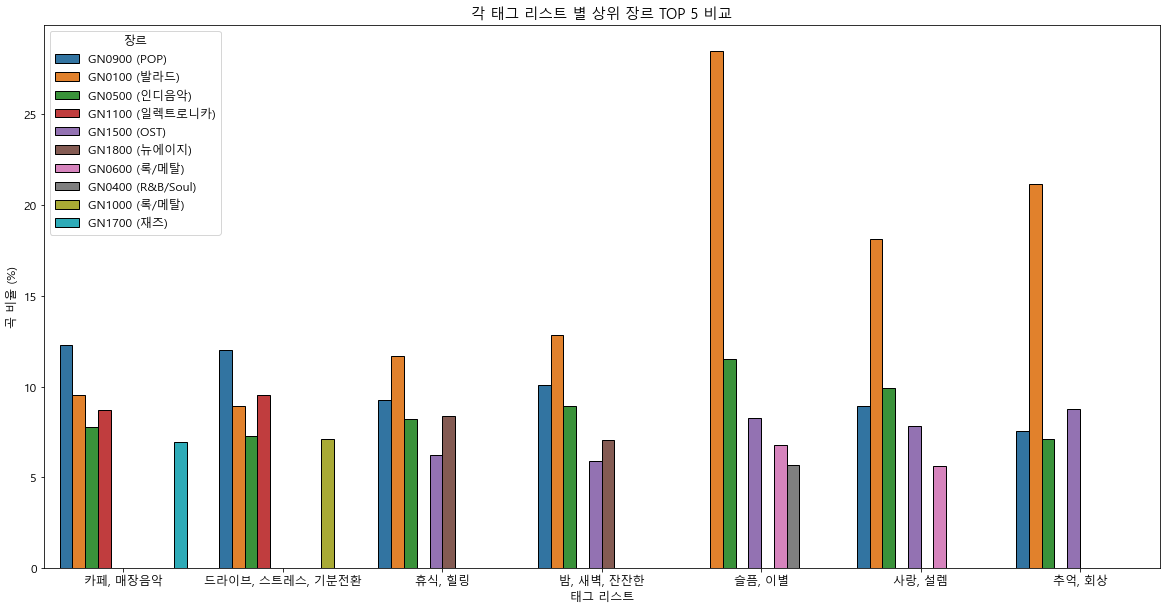

In [57]:
# 각 샘플 태그 리스트 별 장르 비율 집계
song_tag_map_sample_1_gnr_rank = song_tag_map_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_1_gnr_rank['song_cnt']/sum(song_tag_map_sample_1_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_1_gnr_rank['gnr_rank'] = song_tag_map_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환'
song_tag_map_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_2_gnr_rank = song_tag_map_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_2_gnr_rank['song_cnt']/sum(song_tag_map_sample_2_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_2_gnr_rank['gnr_rank'] = song_tag_map_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
song_tag_map_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_3_gnr_rank = song_tag_map_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_3_gnr_rank['song_cnt']/sum(song_tag_map_sample_3_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_3_gnr_rank['gnr_rank'] = song_tag_map_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
song_tag_map_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_4_gnr_rank = song_tag_map_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_4_gnr_rank['song_cnt']/sum(song_tag_map_sample_4_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_4_gnr_rank['gnr_rank'] = song_tag_map_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_4_gnr_rank['tag_list'] = '추억, 회상'
song_tag_map_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_5_gnr_rank = song_tag_map_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_5_gnr_rank['song_cnt']/sum(song_tag_map_sample_5_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_5_gnr_rank['gnr_rank'] = song_tag_map_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
song_tag_map_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_6_gnr_rank = song_tag_map_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_6_gnr_rank['song_cnt']/sum(song_tag_map_sample_6_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_6_gnr_rank['gnr_rank'] = song_tag_map_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
song_tag_map_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_7_gnr_rank = song_tag_map_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_7_gnr_rank['song_cnt']/sum(song_tag_map_sample_7_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_7_gnr_rank['gnr_rank'] = song_tag_map_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
song_tag_map_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

# delete object
del song_tag_map_sample_1, song_tag_map_sample_2, song_tag_map_sample_3, song_tag_map_sample_4, song_tag_map_sample_5, song_tag_map_sample_6, song_tag_map_sample_7

# row binding
song_tag_map_sample_rbind = pd.concat(
    [song_tag_map_sample_1_gnr_rank, song_tag_map_sample_2_gnr_rank, song_tag_map_sample_3_gnr_rank,
     song_tag_map_sample_4_gnr_rank, song_tag_map_sample_5_gnr_rank, song_tag_map_sample_6_gnr_rank,
     song_tag_map_sample_7_gnr_rank],
    axis = 0
)

# plotting
song_tag_map_sample_rbind_plot = sns.barplot(
    data = song_tag_map_sample_rbind.loc[song_tag_map_sample_rbind['순위'] <= 5, :].sort_values(by = '순위'),
    x = '태그 리스트', y = '비율(%)', hue = '장르', edgecolor = "black"
)
song_tag_map_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교')
song_tag_map_sample_rbind_plot.set_xlabel('태그 리스트')
song_tag_map_sample_rbind_plot.set_ylabel('곡 비율 (%)')
plt.show()

- **드라이브, 스트레스, 기분전환 태그가 매핑된 플레이리스트**와 **카페, 매장음악 태그가 매핑된 플레이리스트**에서는 **팝(GN0900) 장르와 일렉(GN1100)장르가 많았습니다.**
- **이 밖에 대부분 태그에서 발라드(GN0100) 곡 비중이 가장 높았으며** 슬픔, 이별 태그가 매핑된 플레이리스트에서는 발라드 비중이 가장 높았습니다.
- 밤, 새벽, 잔잔한, 휴식, 힐링 등의 태그가 있는 플레이리스트에서는 발라드 다음으로 팝 장르 비중이 높았습니다.
- **추억, 회상 태그가 매핑된 플레이리스트에서는 OST 비중이 발라드 다음으로 높습니다.**
- 이와 같이 태그 별 플레이리스트 수록 곡 특징을 탐색하여 플레이리스트의 곡 장르 성격을 추정해볼 수 있습니다.

<br>

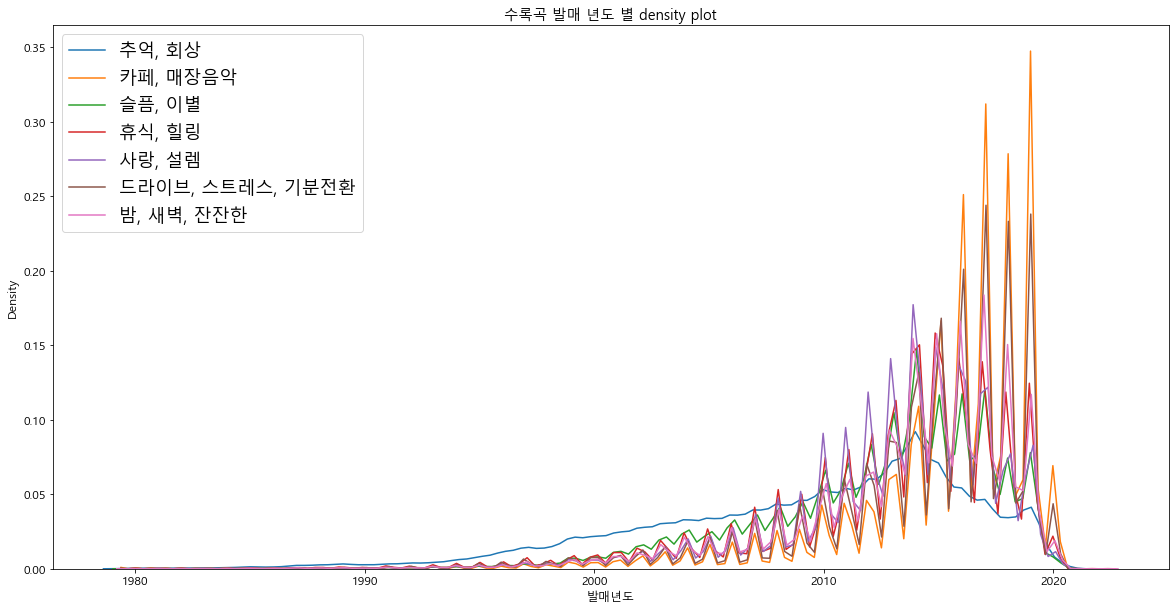

In [58]:
# 위에서 생성한 테이블에서 곡 별 발매년도 join
plylst_song_tag_map_issue_year = pd.merge(plylst_song_tag_map, song_issue_date, how = 'left', left_on = 'songs', right_on = 'song_id')

# 샘플 태그들이 포함되어 있는 플레이리스트만 필터링
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year.loc[plylst_song_tag_map_issue_year.tags.isin(['드라이브', '스트레스', '기분전환', '밤', '새벽', '잔잔한', '사랑', '설렘', '추억', '회상', '슬픔', '이별', '휴식', '힐링', '카페', '매장음악']), :]
plylst_song_tag_map_issue_year_filter['issue_year'] = plylst_song_tag_map_issue_year_filter['issue_year'].apply(pd.to_numeric)
plylst_song_tag_map_issue_year_filter = plylst_song_tag_map_issue_year_filter[plylst_song_tag_map_issue_year_filter['issue_year'] >= 1980]

del plylst_song_tag_map_issue_year

# plotting
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['추억', '회상']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '추억, 회상')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['카페', '매장음악']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '카페, 매장음악')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['슬픔', '이별']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '슬픔, 이별')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['휴식', '힐링']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '휴식, 힐링')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['사랑', '설렘']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '사랑, 설렘')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['드라이브', '스트레스', '기분전환']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '드라이브, 스트레스, 기분전환')
temp_df = plylst_song_tag_map_issue_year_filter.loc[plylst_song_tag_map_issue_year_filter.tags.isin(['밤', '새벽', '잔잔한']), :]
sns.distplot(temp_df['issue_year'], hist = False, kde = True, label = '밤, 새벽, 잔잔한')
plt.legend(prop = {'size' : 18})
plt.title('수록곡 발매 년도 별 density plot')
plt.xlabel('발매년도')
plt.ylabel('Density')
plt.show()

- 이 밖에 발매년도 기준으로 살펴본 결과  
  **추억, 회상이 매핑된 플레이리스트들은 태그명처럼 다른 플레이리스트에 비해 비교적 과거 발매 곡 비중이 조금 더 높은 편**을 확인할 수 있습니다.

<br>

### 역으로 곡 별 태그를 매핑해본다면?

- 각 플레이리스트에 한 개 이상의 태그들이 매핑되어 있고, 한 곡 이상의 곡들이 수록되어 있습니다.
- 이 부분을 고려하여 **곡 별 수록된 플레이리스트의 태그 값을 매핑**해본다면 **곡의 메타 정보를 하나 더 파생**시켜서 볼 수 있습니다.

In [59]:
# 학습 데이터 내에서 가장 많은 태그가 매핑된 아이유 - 밤편지 (144663) 예시
example_song = plylst_song_tag_map[plylst_song_tag_map['songs'] == '144663']
example_song

,id,songs,tags,gnr_code_name
36032,7984,144663,슬픔,GN0100 (발라드)
36033,7984,144663,거짓말,GN0100 (발라드)
36034,7984,144663,이별,GN0100 (발라드)
36035,7984,144663,아픈,GN0100 (발라드)
115027,106802,144663,힐링,GN0100 (발라드)
...,...,...,...,...
29580419,13178,144663,새벽,GN0100 (발라드)
29580420,13178,144663,새벽아침,GN0100 (발라드)
29580421,13178,144663,활기찬,GN0100 (발라드)
29580422,13178,144663,산책,GN0100 (발라드)


In [60]:
# 곡 별 매핑되는 태그 수 집계 : song_tag_map_cnt
song_tag_map_cnt = plylst_song_tag_map.groupby('songs').tags.nunique().reset_index(name = 'tags_cnt')
round(song_tag_map_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
tags_cnt,1.0,2.0,7.0,17.86,15.0,1928.0,44.95


- 곡 별로 매핑된 태그 값은 **평균 18개**(중앙값 7개)이고 예시로 들었던 아이유 - 밤편지 곡은 1,928개의 태그가 매핑됩니다.

#### 태그 기준으로 유사 느낌의 곡 찾기 (아이유 - 밤편지 곡을 예시로 살펴보기)

In [61]:
example_song.groupby(['songs', 'tags']).id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)

,songs,tags,mapping_plylst_cnt
241,144663,감성,690
770,144663,발라드,543
1462,144663,잔잔한,413
1699,144663,카페,395
940,144663,새벽,339
...,...,...,...
782,144663,밤공기,1
781,144663,밤감성,1
779,144663,발랄한노래,1
778,144663,발라드핫트랙,1


- 아이유 - 밤편지 곡은 **`감성` 태그를 갖는 690개의 플레이리스트에 수록**되어 있습니다.  
  두 번째로 높은 태그는 `발라드`, 세 번째는 `잔잔한` 태그 입니다.

In [62]:
example_temp = plylst_song_tag_map.loc[plylst_song_tag_map['tags'] == '감성', :].groupby('songs').id.nunique().reset_index(name = 'mapping_plylst_cnt').sort_values(by = 'mapping_plylst_cnt', ascending = False)
pd.merge(example_temp, song_meta[['id', 'song_name', 'artist_name_basket']], how = 'left', left_on = 'songs', right_on = 'id').head(10)

,songs,mapping_plylst_cnt,id,song_name,artist_name_basket
0,357367,735,357367,비,[폴킴]
1,144663,690,144663,밤편지,[아이유]
2,519391,678,519391,Love Again,[김제훈]
3,640657,667,640657,내가 말하고 싶은건,[김제훈]
4,463173,662,463173,비가 내렸어 (Vocal by 스티브언니),[업라이트 (Upright)]
5,349492,659,349492,어떤이별,[임승부]
6,427724,653,427724,지워줄게 (Vocal by 스티브언니),[아재]
7,680366,650,680366,끝내지 못한 이야기 (Feat. 호수),[어쿠스틱 멜로디 (Acoustic Melody)]
8,520093,641,520093,고마운 사람 (Vocal by 이소진),[업라이트 (Upright)]
9,215411,639,215411,지금보다 조금 (Feat. 이원),[어쿠스틱 멜로디 (Acoustic Melody)]


- 감성이라는 태그에 매핑되는 곡은 대략 10만곡으로 매핑 수 기준 상위 10곡 입니다.

<br>